### generate an image and simulate the traj. Accumulate the imgae on the fly
- overdamped langevin BM trajectory is simulated and observerd by a camera with exposure time
- no lag between to frames, no space between pxls, no delay in readout time for different pxl rows
- gaussian background noise on the camera pxls (much lower than the signal)
- not memory hungry but need lots of Calc power (probably due to poor programming style...)
---
- i used to bin the camera by 10, otherwise calc takes to long
- units are poorly and mostly not intuitively choosen...

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from copy import deepcopy
from scipy import ndimage

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.rcParams.update({'font.size': 14,
                     'axes.titlesize': 18,
                     'axes.labelsize': 18,
                     'axes.labelpad': 14,
                     'lines.linewidth': 3,
                     'lines.markersize': 5,
                     'xtick.labelsize' : 16,
                     'ytick.labelsize' : 16,
                     'xtick.top' : True,
                     'xtick.direction' : 'in',
                     'ytick.right' : True,
                     'ytick.direction' : 'in',})  

In [2]:

#------------- OLD working params -------------------- takes many hours to compute!
# define all params
total_time = 30  # in s
exposure_time = 0.03  # in s
time_discretization_factor = 6 # dt = expo./dime_disc.

Iterations = int(total_time//exposure_time*time_discretization_factor)
N_frames = int(total_time//exposure_time)   # number of camera frames 

N_runs = 20    # the number of indipendent trajs (needed because at some point the particle leaves the field of view...)

subpxl_factor = 20  # how many 'subpxls' per camera pxl
binning = 10
N_pxl_camera = 512//binning # the number of pxls on the camera
N_pxl_original = int(N_pxl_camera*subpxl_factor) # the 'subpxls' of the image 'in between' aka. im to lazy to analytically integrate the Gauß in 2D...
particle_size = 20  # the size of the particle meassured in the ????? check it out yourself sry...
plx_mu_cam = 1 #0.117
pxl_mu_orig = 1 #plx_mu_cam/subpxl_factor

noise_mean = 100
noise_var = 10
particle_intensity = 2e10  / N_pxl_camera**2 / N_pxl_original**2  #/ particle_size**2
Background_Th = 5*noise_mean

D_trans = 100*0.4/2#*500
seed = 4
np.random.seed(seed)
#### -------END OLD ----------------------

In [307]:
# define all params
total_time = 10  # in s
inverse_framerate = 0.03 # in s
exposure_time = 1 * inverse_framerate  # in s    

time_discretization_factor = 18 # dt = expo./dime_disc.  so many steps during one exposure
deadtime_i = 0

Iterations = int(total_time//exposure_time*time_discretization_factor)
N_frames = int(total_time//exposure_time)   # number of camera frames 

N_runs = 10    # the number of indipendent trajs (needed because at some point the particle leaves the field of view...)

subpxl_factor = 10  # how many 'subpxls' per camera pxl
binning = 10
N_pxl_camera = 512//binning # the number of pxls on the camera
N_pxl_original = int(N_pxl_camera*subpxl_factor) # the 'subpxls' of the image 'in between' aka. im to lazy to analytically integrate the Gauß in 2D...
particle_size = 7  # the size of the particle meassured in the ????? check it out yourself sry...
plx_mu_cam = 0.1 #0.117
pxl_mu_orig = plx_mu_cam * subpxl_factor #plx_mu_cam/subpxl_factor

noise_mean = 100
noise_var = 10
particle_intensity = 2e10  / N_pxl_camera**2 / N_pxl_original**2  / (1 - deadtime_i/time_discretization_factor) #/ particle_size**2
Background_Th = 5*noise_mean

D_trans = 100*0.4 # in µm^2/s
seed = 4
np.random.seed(seed)


In [308]:
#images_cam = np.zeros((N_runs,N_frames, N_pxl_camera,N_pxl_camera))
x_list = np.zeros((N_runs,Iterations))
y_list = np.zeros((N_runs,Iterations))

x_list[:,0] = N_pxl_original/2
y_list[:,0] = N_pxl_original/2


x_Camera = np.zeros((N_runs, N_frames))
y_Camera = np.zeros((N_runs, N_frames))

x_camera_plx_list = np.linspace(1,N_pxl_camera,N_pxl_camera)
x_orig_plx_list = (np.linspace(1,N_pxl_original,N_pxl_original)-0.5)*1

x_orig_pxl_pos_M = np.meshgrid(x_orig_plx_list,x_orig_plx_list)[0]
y_orig_pxl_pos_M = np.meshgrid(x_orig_plx_list,x_orig_plx_list)[1]


In [309]:
def Gauss_2D(x_pxl,y_pxl,x,y,s):
    return np.exp(-((x_pxl-x)**2+(y_pxl-y)**2)/(4*s**2)) # *1/(2*np.pi*s**2)

In [310]:
def Find_particle_position(image):
    from copy import deepcopy
    from scipy import ndimage
    image_copy = deepcopy(image)
    image_copy[image_copy < Background_Th] = 0
    image_copy[image_copy >= Background_Th] = 1
    x_COM, y_COM= ndimage.measurements.center_of_mass(image_copy)
    return x_COM,y_COM

In [311]:
#fill the images
# the camera pxl is the cummulated original
k = 0
x_gauss_list = np.random.normal(scale = np.sqrt(2*D_trans*exposure_time),size = (N_runs,Iterations))
y_gauss_list = np.random.normal(scale = np.sqrt(2*D_trans*exposure_time),size = (N_runs,Iterations))

#do the sim:
for n in range(N_runs):
    for i in range(1,Iterations):
        x_list[n,i] = x_list[n,i-1] + x_gauss_list[n,i]
        y_list[n,i] = y_list[n,i-1] + y_gauss_list[n,i]



    


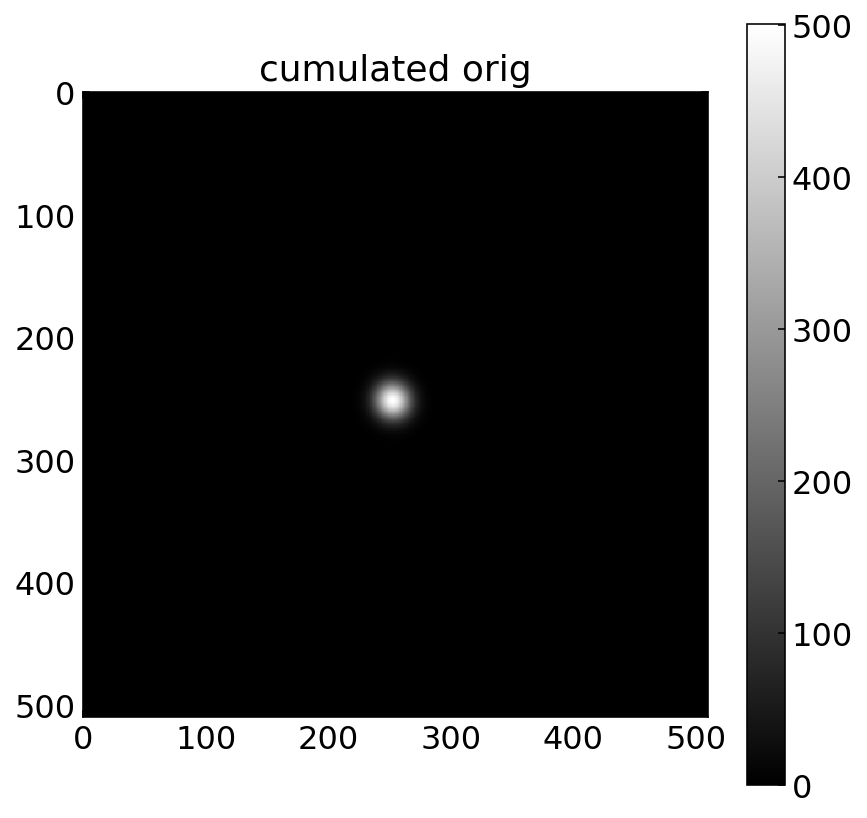

 [ 4% ] 1 run of 10===

KeyboardInterrupt: 

In [312]:
from IPython.display import clear_output
import os, sys
for n in range(N_runs):
    clear_output()
    prog = 0
    for frame in range(N_frames):
        #if frame!=0:
        #    print('break')
        #    break
        current_x_list = x_list[n,time_discretization_factor*frame:time_discretization_factor*(frame+1)]
        current_y_list = y_list[n,time_discretization_factor*frame:time_discretization_factor*(frame+1)]
        cumulated_orig_im = np.zeros((N_pxl_original,N_pxl_original))
        for subframe in range(time_discretization_factor-deadtime_i):
            cumulated_orig_im += particle_intensity*Gauss_2D(x_orig_pxl_pos_M,y_orig_pxl_pos_M,current_x_list[subframe],current_y_list[subframe],particle_size)
        camera_image = np.zeros((N_pxl_camera,N_pxl_camera))
        for cam_x in range(N_pxl_camera):
            for cam_y in range(N_pxl_camera):
                camera_image[cam_x,cam_y] = np.sum(cumulated_orig_im[(cam_x)*subpxl_factor:(cam_x+1)*subpxl_factor,(cam_y)*subpxl_factor:(cam_y+1)*subpxl_factor]) + np.abs(np.random.normal(scale = noise_var,loc = noise_mean))
        if (frame == 0 or frame == N_frames-1) and n==0:  # plot the frirst and last
            plt.figure(figsize=(7,7))
            plt.title('camera')
            plt.imshow(camera_image,interpolation='none',cmap = 'gray')
            plt.colorbar()
            plt.show()
            plt.figure(figsize=(7,7))
            plt.title('cumulated orig')
            plt.imshow(cumulated_orig_im,interpolation='none',cmap = 'gray')
            plt.colorbar()
            plt.show()

            image_copy = deepcopy(camera_image)
            image_copy[image_copy < Background_Th] = 0
            image_copy[image_copy >= Background_Th] = 1
            #x_COM, y_COM= ndimage.measurements.center_of_mass(image_copy)
            plt.figure(figsize=(7,7))
            plt.title('after TH')
            plt.imshow(image_copy,interpolation='none',cmap = 'gray')
            plt.colorbar()
            plt.show()


        x_Camera[n,frame],y_Camera[n,frame] = Find_particle_position(camera_image)


        if int((frame)/N_frames*100) == prog:
                prog +=1
                sys.stdout.write('='+(''*(100-int(frame/N_frames*100) + 1))+("\r [ %d"%int(frame/N_frames*100 + 1)+"% ] ") + "{:} run of {:}".format(n+1,N_runs))
                sys.stdout.flush()
    print('run ',n,' of ',N_runs)



In [279]:
# center all the trajs.
for n in range(N_runs):
    x_Camera[n] = x_Camera[n] - x_Camera[n,0]
    y_Camera[n] = y_Camera[n] - y_Camera[n,0]
    x_list[n] = (x_list[n] - x_list[n,0])/subpxl_factor
    y_list[n] = (y_list[n] - y_list[n,0])/subpxl_factor




In [280]:
## if the traj was to big for the field of view:
x_Camera_old = x_Camera
y_Camera_old = y_Camera
#N = 9000
#x_Camera = x_Camera[:N]
#y_Camera = y_Camera[:N]

x_list_old = x_list
y_list_old = y_list
#x_list = x_list[:N*time_discretization_factor]
#y_list = y_list[:N*time_discretization_factor]



In [281]:
np.save('x_Camera',x_Camera)
np.save('y_Camera',y_Camera)

np.save('x_list',x_list)
np.save('y_list',y_list)


In [282]:
x_Camera = np.load('x_Camera.npy')
y_Camera = np.load('y_Camera.npy')
x_list = np.load('x_list.npy')
y_list = np.load('y_list.npy')







In [283]:
np.max([np.abs(x_Camera[np.isfinite(x_Camera)]),np.abs(y_Camera[np.isfinite(y_Camera)])])

19.571428571428573

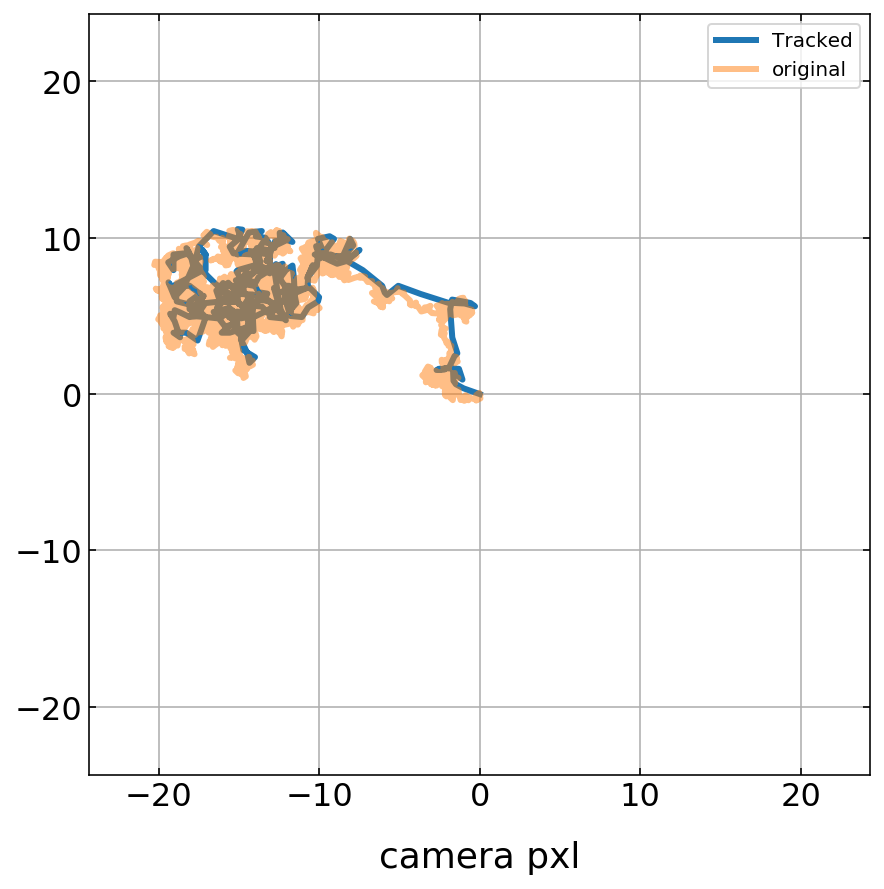

In [284]:
plt.figure(figsize=(7,7))
#plt.plot(x_Camera[np.isfinite(x_Camera)],y_Camera[np.isfinite(y_Camera)])
#N = 9000
plt.plot(x_Camera[0],y_Camera[0],alpha = 1, label = 'Tracked')
plt.plot(y_list[0],x_list[0],alpha = 0.5,label = 'original')
max_value = 1.2*np.max([np.max([np.abs(x_list[0]),np.abs(y_list[0])]),np.max([np.abs(x_Camera[0]),np.abs(y_Camera[0])])])
plt.xlim(-max_value, max_value)
plt.ylim(-max_value, max_value)
plt.legend()
plt.grid()
plt.xlabel('camera pxl')
plt.savefig('traj.pdf')
plt.show()

In [285]:
print(len(x_Camera))
print(len(x_list))

10
10


In [286]:
def CALC_VAC(x_list,y_list):
    max_dt = 10
    Vac_list = np.zeros(max_dt)
    dt_list = np.array(range(1,max_dt+1))*exposure_time
    if 1:
        dx_list = x_list[1:]-x_list[:-1]
        dy_list = y_list[1:]-y_list[:-1]   
    Vac_list[0] = np.mean(dx_list*dx_list + dy_list*dy_list )
    for di in range(1,max_dt):
        if 1:
            vac = np.mean(dx_list[di::di]*dx_list[:-di:di] + dy_list[di::di]*dy_list[:-di:di] )  #stat indi
        else:
            vac = np.mean(dx_list[di:]*dx_list[:di])
        
        
        Vac_list[di] = vac
    return dt_list , Vac_list/Vac_list[0]
#dt_list , VAC_list = Make_VAC(x_Camera,y_Camera)

In [287]:
max_dt = 10
VAC_ll = np.zeros((N_runs,max_dt))
VAC_ll_orig = np.zeros((N_runs,max_dt))

for n in range(N_runs):
    dt_list, vac_list = CALC_VAC(x_Camera[n],y_Camera[n])
    VAC_ll[n] = vac_list
    dt_list, vac_list_orig = CALC_VAC(x_list[n,::time_discretization_factor],y_list[n,::time_discretization_factor])
    dt_list, vac_list_orig = CALC_VAC(x_list[n,:],y_list[n,:])
    VAC_ll_orig[n] = vac_list_orig
    
VAC_list = np.zeros(len(dt_list))
VAC_list_orig = np.zeros(len(dt_list))
for i in range(len(dt_list)):
    VAC_list[i] = np.mean(VAC_ll[:,i])
    VAC_list_orig[i] = np.mean(VAC_ll_orig[:,i])

plt.figure()
#plt.scatter(*CALC_VAC(x_Camera,y_Camera),label = 'tracked')
plt.scatter(dt_list, VAC_list,label = 'tracked',marker = 'x')
#plt.scatter(*CALC_VAC(x_list[::time_discretization_factor],y_list[::time_discretization_factor]),c='r',label='orig')
plt.scatter(dt_list,VAC_list_orig,c='r',label='orig',marker = '+')
plt.legend()
plt.title('VAC (normalized) $t_{expo}/t_{framerate}$ ='+ str(time_discretization_factor-deadtime_i)+'/'+str(time_discretization_factor))
plt.savefig('VAC_{:}of{:}Exposure.pdf'.format(time_discretization_factor-deadtime_i,time_discretization_factor))
plt.xlabel('dt [s]')
plt.grid()
plt.show()

In [253]:
def CALC_MSD(x_list,y_list):
    MSD_list = np.zeros(max_dt)
    dt_list = np.array(range(1,max_dt+1))*exposure_time
    #dx_list = x_list[1:]-x_list[:-1]
    #dy_list = y_list[1:]-y_list[:-1]
    for di in range(1,max_dt+1):
        if 0:
            dx_list = x_list[di:]-x_list[:-di]
            dy_list = y_list[di:]-y_list[:-di]
        else: # stat indi
            dx_list = x_list[::di][1:] - x_list[::di][:-1]
            dy_list = y_list[::di][1:] - y_list[::di][:-1]
            
            
        MSD_list[di-1] = np.mean(dx_list**2 + dy_list**2)
                    
            
    return dt_list, MSD_list

In [254]:
#print(Make_MSD(x_Camera,y_Camera))
max_dt = 20
MSD_ll = np.zeros((N_runs,max_dt))
MSD_ll_orig = np.zeros((N_runs,max_dt))

for n in range(N_runs):
    dt_list, msd_list = CALC_MSD(x_Camera[n],y_Camera[n])
    MSD_ll[n] = msd_list
    dt_list, msd_list_orig = CALC_MSD(x_list[n,::time_discretization_factor],y_list[n,::time_discretization_factor])
    MSD_ll_orig[n] = msd_list_orig
    
MSD_list = np.zeros(len(dt_list))
MSD_list_orig = np.zeros(len(dt_list))
for dti in range(len(dt_list)):
    MSD_list[dti] = np.mean(MSD_ll[:,dti])
    MSD_list_orig[dti] = np.mean(MSD_ll_orig[:,dti])

    
print(dt_list[0]*4*D_trans)
print(MSD_list_orig[0])
print(dt_list[0]*4*D_trans/MSD_list_orig[0])

plt.figure(figsize=(7,7))
plt.scatter(dt_list,MSD_list,label = 'tracked')
plt.scatter(dt_list, MSD_list_orig,c='r',label='orig')
plt.plot(dt_list,dt_list*4*D_trans/subpxl_factor**2*time_discretization_factor, c = 'orange', label = 'analytical')
plt.title('MSD')
plt.xlabel('dt [s]')
plt.ylabel('msd arbit units')
plt.xscale('log')
plt.yscale('log')
#plt.grid()
plt.legend()
plt.savefig('msd.pdf')
plt.show()

4.8
0.8503902600180024
5.644467282466741


In [50]:
plt.hist2d()

16.666666666666668

In [51]:
dx_

10

In [52]:
time_discretization_factor

6

In [53]:
53/165

0.3212121212121212

In [81]:
2.2/165*25

0.33333333333333337

In [80]:
np.sqrt(30)

5.477225575051661

In [83]:
0.04*1.5

0.06

[ 0.52802579  1.51280082 -1.06666667 -0.37534172  0.74814619 -0.671875
  1.32356532  5.09205549  0.50409836  0.45006105  4.57397108  0.62182203
 -1.13309253  0.60586494 -1.14141414 -0.56120219  1.57849462 -2.42622951
 -1.66308244 -4.38453661 -0.49233716]


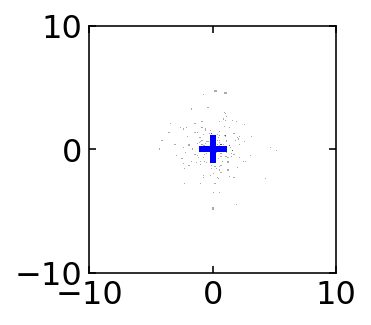

<Figure size 432x288 with 0 Axes>

In [119]:
def Make_2D_diplacement_hist(ax,x_list,y_list,dti=1):
    if 0:
        dx_list = x_list[dti:]-x_list[:-dti]
        dy_list = y_list[dti:]-y_list[:-dti]
    else: # only stat indi.
        dx_list = x_list[::dti][1:] - x_list[::dti][:-1]
        dy_list = y_list[::dti][1:] - y_list[::dti][:-1]
    
    n_bins = 100
    a = 10
    xedges = np.linspace(-a,a,n_bins)
    yedges = np.linspace(-a,a,n_bins)
    dx = xedges[1]-xedges[0]
    H, xedges, yedges = np.histogram2d(dx_list, dy_list, bins=(xedges, yedges))
    ax.imshow(H, interpolation='none', extent=[xedges[0]+dx, xedges[-1]+dx, yedges[0]+dx, yedges[-1]+dx],cmap = 'gray_r')
    ax.scatter(0,0,marker = '+',color = 'blue',s = 200)
    ax.hist2d(dx_list,dy_list,bins=100,cmap = 'gray_r')
    b = a/1
    ax.set_xlim(xmin = -b, xmax = b)
    ax.set_ylim(ymin = -b, ymax = b)
    
    
    
    ##cummulative x slice
    dx_list_slice = dx_list[np.abs(dy_list)<0.2]
    print(dx_list_slice)
    
    plt.figure()
    plt.plot(xedges[:-1]+dx, H[len(H)//2]*20)
    #plt.hist(dx_list[dr_list!=0],bins = n_bins,alpha = 0.5)
    #plt.hist(dy_list[dr_list!=0],bins = n_bins,alpha = 0.5)
    #plt.hist(dr_list[dr_list!=0],bins = n_bins,alpha = 0.5)
    plt.title('xslice, dx data')
    plt.xlabel('x [pxl]')
    plt.ylabel('counts')
    #plt.savefig('pixelation_effect.pdf')
    plt.show()
    
    plt.figure()
    
    
    return
dti = 2
fig = plt.figure(figsize=(10, 5))
fig.patch.set_facecolor('white')
ax1 = fig.add_subplot(211)


Make_2D_diplacement_hist(ax1,x_Camera[np.isfinite(x_Camera)],y_Camera[np.isfinite(y_Camera)],dti=dti)
#ax2 = fig.add_subplot(111)
#Make_2D_diplacement_hist(ax2,x_list[::time_discretization_factor],y_list[::time_discretization_factor],dti=dti)

plt.show()
